#### Transfer Learning Modell 1
- Backbone VGG-16
- Images cropped and resized
- Colorscheme original
- Preprocess input will scale pixels between -1 and 1, sample-wise.

Sources for use and issue resolving:
- https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
- https://arxiv.org/abs/1409.1556
- https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py#L157

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras_preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datensätze/train4_small.csv')

In [6]:
df.head()

,filename,labels
0,3f58d128caf6.jpg,glaucoma
1,802b4bfabd52.jpg,md
2,7bcfab1fa2da.jpg,opacity
3,012e91949ec4.jpg,opacity
4,6386346fb595.jpg,opacity


In [7]:
# Original Images
in_dir = '/content/drive/MyDrive/Datensätze/four'

### Image Generator

In [8]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.25)

In [9]:
train_gen = datagen.flow_from_dataframe(dataframe = df, 
                                            directory = in_dir, 
                                            x_col = "filename", 
                                            y_col = 'labels',
                                            batch_size = 10, 
                                            seed = 2, 
                                            shuffle = True, 
                                            class_mode = "categorical", 
                                            classes = ['opacity', 'glaucoma','md', 'normal'],
                                            subset='training',
                                            target_size = (224,224))

Found 1500 validated image filenames belonging to 4 classes.


In [10]:
val_gen = datagen.flow_from_dataframe(dataframe = df, 
                                            directory = in_dir, 
                                            x_col = "filename", 
                                            y_col = 'labels',
                                            batch_size = 10, 
                                            seed = 2, 
                                            shuffle = False,#Labels nicht shuffeln für CM 
                                            class_mode = "categorical", 
                                            classes = ['opacity', 'glaucoma','md', 'normal'],
                                            subset='validation',
                                            target_size = (224,224))

Found 500 validated image filenames belonging to 4 classes.


In [11]:
imgs, labels = next(train_gen)

In [12]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

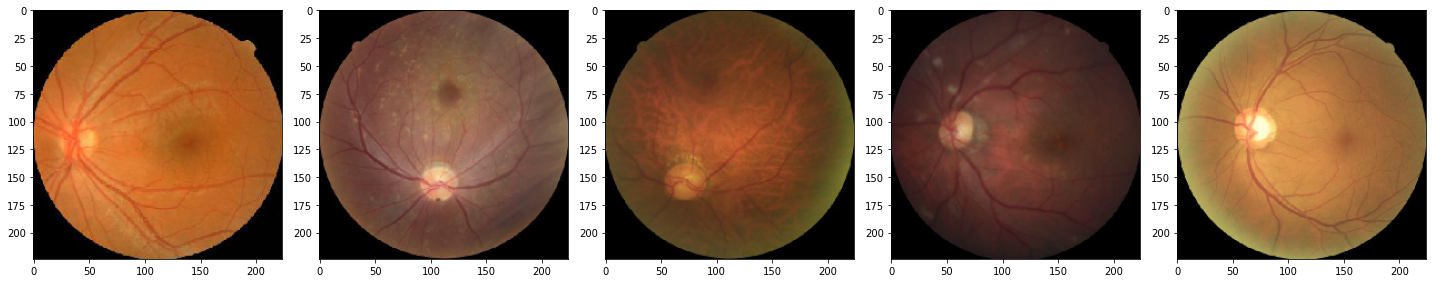

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [13]:
plotImages(imgs)
print(labels)

### Get VGG16 Pretrained Model

In [14]:
model_vgg16 = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [15]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# Build sequentail model
model = Sequential()
for layer in model_vgg16.layers[:-1]:
    model.add(layer)

In [17]:
# freeze trainable parameters for all layers in the model
for layer in model.layers:
    layer.trainable = False

In [18]:
# my output layer for four output classes, activation for multi-class classification
model.add(Dense(units=4, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, None, None, None)  0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, None, None, 64)    1792      
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, None, None, 64)    36928     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, None, None, 64)    0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, None, None, 128)   73856     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, None, None, 128)   147584    
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, None, None, 128)   0

In [20]:
step_size_train = train_gen.n//train_gen.batch_size
step_size_val = val_gen.n//val_gen.batch_size

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(x=train_gen, validation_data=val_gen, steps_per_epoch=step_size_train, 
          validation_steps=step_size_val, epochs=10,verbose=2)

Epoch 1/10
150/150 - 1055s - loss: 1.3219 - accuracy: 0.4133 - val_loss: 1.2824 - val_accuracy: 0.4060
Epoch 2/10
150/150 - 1022s - loss: 1.1218 - accuracy: 0.5340 - val_loss: 1.8264 - val_accuracy: 0.3540
Epoch 3/10
150/150 - 1024s - loss: 1.0039 - accuracy: 0.5707 - val_loss: 1.2421 - val_accuracy: 0.4460
Epoch 4/10
150/150 - 1024s - loss: 0.9624 - accuracy: 0.5873 - val_loss: 0.9909 - val_accuracy: 0.5760
Epoch 5/10
150/150 - 1027s - loss: 0.8877 - accuracy: 0.6360 - val_loss: 1.0093 - val_accuracy: 0.5780
Epoch 6/10
150/150 - 1025s - loss: 0.9113 - accuracy: 0.5960 - val_loss: 0.9284 - val_accuracy: 0.5980
Epoch 7/10
150/150 - 1027s - loss: 0.8634 - accuracy: 0.6493 - val_loss: 0.8748 - val_accuracy: 0.6420
Epoch 8/10
150/150 - 1026s - loss: 0.7826 - accuracy: 0.6647 - val_loss: 1.1281 - val_accuracy: 0.5120
Epoch 9/10
150/150 - 1025s - loss: 0.8586 - accuracy: 0.6447 - val_loss: 1.1575 - val_accuracy: 0.5200
Epoch 10/10
150/150 - 1023s - loss: 0.8038 - accuracy: 0.6673 - val_loss:

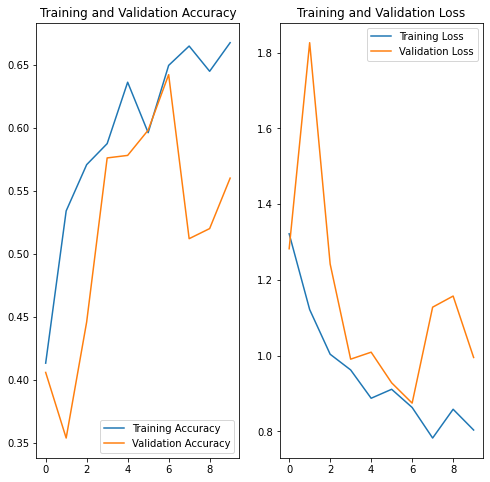

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model.save('/content/drive/MyDrive/Transfer Learning/Savemodel_2.1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Transfer Learning/Savemodel_2.1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Transfer Learning/Savemodel_2.1/assets
